In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

In [6]:
from matplotlib import pyplot as plt

In [7]:
!pip install photutils

## Source Extraction Using Image Segmentation

Photutils provides tools to detect astronomical sources using image segmentation, which is a process of assigning a label to every pixel in an image such that pixels with the same label are part of the same source. The segmentation procedure implemented in Photutils is called the threshold method, where detected sources must have a minimum number of connected pixels that are each greater than a specified threshold value in an image. The threshold level is usually defined at some multiple of the background noise (sigma) above the background. The image can also be filtered before thresholding to smooth the noise and maximize the detectability of objects with a shape similar to the filter kernel.

Let’s start by detecting sources in a synthetic image provided by the photutils.datasets module:

In [22]:
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image()

The source segmentation/extraction is performed using the detect_sources() function. We will use a convenience function called detect_threshold() to produce a 2D detection threshold image using simple sigma-clipped statistics to estimate the background level and RMS.

The threshold level is calculated using the nsigma input as the number of standard deviations (per pixel) above the background. Here we generate a simple threshold at 2 sigma (per pixel) above the background:

In [23]:
from photutils import detect_threshold
threshold = detect_threshold(data, nsigma=2.)

For more sophisticated analyses, one should generate a 2D background and background-only error image (e.g., from your data reduction or by using Background2D). In that case, a 2-sigma threshold image is simply:

In [24]:
threshold = bkg + (2.0 * bkg_rms)  

NameError: name 'bkg_rms' is not defined

Note that if the threshold includes the background level (as above), then the image input into detect_sources() should not be background subtracted. In other words, the input threshold value(s) are compared directly to the input image. Because the threshold returned by detect_threshold() includes the background, we do not subtract the background from the data here.

Let’s find sources that have 5 connected pixels that are each greater than the corresponding pixel-wise threshold level defined above (i.e., 2 sigma per pixel above the background noise). Note that by default “connected pixels” means “8-connected” pixels, where pixels touch along their edges or corners. One can also use “4-connected” pixels that touch only along their edges by setting connectivity=4 in detect_sources().

We will also input a 2D circular Gaussian kernel with a FWHM of 3 pixels to smooth the image some prior to thresholding:

In [25]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)

The result is a SegmentationImage object with the same shape as the data, where detected sources are labeled by different positive integer values. A value of zero is always reserved for the background. Let’s plot both the image and the segmentation image showing the detected sources:

Text(0.5, 1.0, 'Segmentation Image')

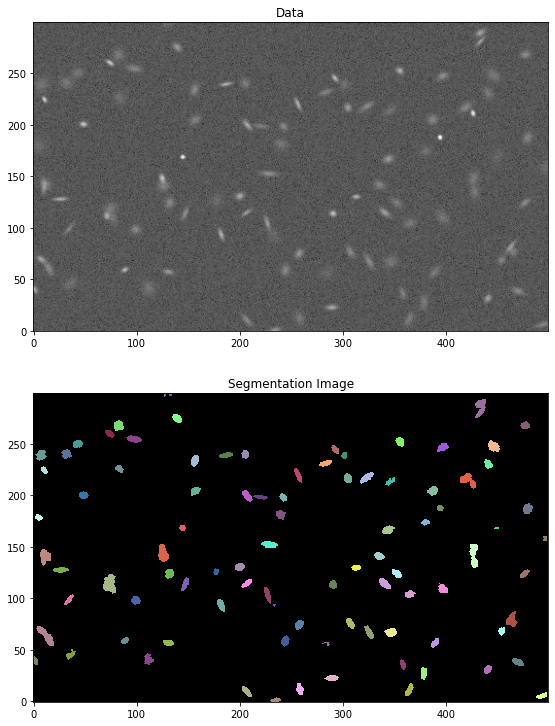

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')

## Source Deblending

n the example above, overlapping sources are detected as single sources. Separating those sources requires a deblending procedure, such as a multi-thresholding technique used by SExtractor. Photutils provides a deblend_sources() function that deblends sources uses a combination of multi-thresholding and watershed segmentation. Note that in order to deblend sources, they must be separated enough such that there is a saddle between them.

The amount of deblending can be controlled with the two deblend_sources() keywords nlevels and contrast. nlevels is the number of multi-thresholding levels to use. contrast is the fraction of the total source flux that a local peak must have to be considered as a separate object.

Here’s a simple example of source deblending:

In [28]:
from photutils import deblend_sources
segm_deblend = deblend_sources(data, segm, npixels=5,
                               filter_kernel=kernel, nlevels=32,
                               contrast=0.001)

where segm is the SegmentationImage that was generated by detect_sources(). Note that the npixels and filter_kernel input values should match those used in detect_sources() to generate segm. The result is a new SegmentationImage object containing the deblended segmentation image:

Text(0.5, 1.0, 'Segmentation Image')

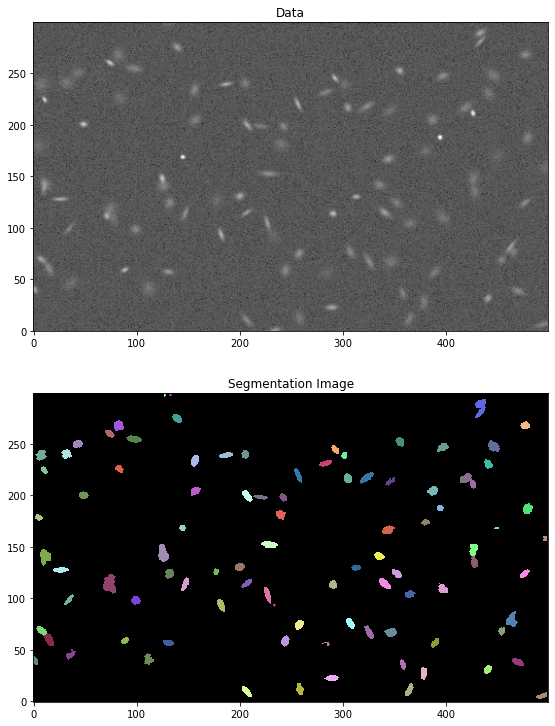

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')

## Centroids, Photometry, and Morphological Properties

The source_properties() function is the primary tool for measuring the centroids, photometry, and morphological properties of sources defined in a segmentation image. When the segmentation image is generated using image thresholding (e.g., using detect_sources()), the source segments represent the isophotal footprint of each source and the resulting photometry is effectively isophotal photometry.

source_properties() returns a SourceCatalog object, which acts in part like a list of SourceProperties objects, one for each segmented source (or a specified subset of sources). An Astropy QTable of source properties can be generated using the to_table() method. Please see SourceProperties for the list of the many properties that are calculated for each source. More properties are likely to be added in the future.

Let’s detect sources and measure their properties in a synthetic image. For this example, we will use the Background2D class to produce a background and background noise image. We define a 2D detection threshold image using the background and background RMS images. We set the threshold at 2 sigma (per pixel) above the background:

In [30]:
from astropy.convolution import Gaussian2DKernel
from photutils.datasets import make_100gaussians_image
from photutils import Background2D, MedianBackground
from photutils import detect_threshold, detect_sources
data = make_100gaussians_image()
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
threshold = bkg.background + (2. * bkg.background_rms)

Now we find sources that have 5 connected pixels that are each greater than the corresponding threshold image defined above. Because the threshold includes the background, we do not subtract the background from the data here. We also input a 2D circular Gaussian kernel with a FWHM of 3 pixels to filter the image prior to thresholding:

In [31]:
from astropy.stats import gaussian_fwhm_to_sigma
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
npixels = 5
segm = detect_sources(data, threshold, npixels=npixels,
                      filter_kernel=kernel)
segm_deblend = deblend_sources(data, segm, npixels=npixels,
                               filter_kernel=kernel, nlevels=32,
                               contrast=0.001)

As described earlier, the result is a SegmentationImage where sources are labeled by different positive integer values.

Now let’s measure the properties of the detected sources defined in the segmentation image using the simplest call to source_properties(). The output QTable of source properties is generated by the SourceCatalog to_table() method. Each row in the table represents a source. The columns represent the calculated source properties. Note that the only a subset of the source properties are shown below. Please see SourceProperties for the list of the many properties that are calculated for each source:

In [32]:
from photutils import source_properties
cat = source_properties(data, segm_deblend)
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['cxx'].info.format = '.2f'
tbl['cxy'].info.format = '.2f'
tbl['cyy'].info.format = '.2f'
tbl['gini'].info.format = '.2f'
print(tbl)

 id xcentroid ycentroid sky_centroid ...   cxx      cxy      cyy    gini
       pix       pix                 ... 1 / pix2 1 / pix2 1 / pix2     
--- --------- --------- ------------ ... -------- -------- -------- ----
  1    235.22      1.25         None ...     0.17    -0.20     0.99 0.18
  2    493.82      5.77         None ...     0.16    -0.32     0.61 0.13
  3    207.30     10.02         None ...     0.37     0.49     0.30 0.16
  4    364.75     11.13         None ...     0.39    -0.33     0.18 0.13
  5    258.37     11.77         None ...     0.37     0.15     0.16 0.13
  6    289.49     22.41         None ...     0.12    -0.04     0.54 0.22
  7    379.28     27.29         None ...     0.41    -0.01     0.10 0.12
  8    441.34     31.08         None ...     0.33    -0.17     0.27 0.20
  9    358.49     35.87         None ...     0.66     0.30     0.20 0.15
 10    470.51     38.45         None ...     0.15     0.23     0.37 0.16
...       ...       ...          ... ...      ...  

Let’s use the measured morphological properties to define approximate isophotal ellipses for each source. Here we define an EllipticalAperture object for each source using its calculated centroid positions (xcentroid and ycentroid) , semimajor and semiminor axes lengths (semimajor_axis_sigma and semiminor_axis_sigma) , and orientation (orientation):

In [33]:
import numpy as np
import astropy.units as u
from photutils import source_properties, EllipticalAperture
cat = source_properties(data, segm_deblend)
r = 3.  # approximate isophotal extent
apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

Now let’s plot the derived elliptical apertures on the data:

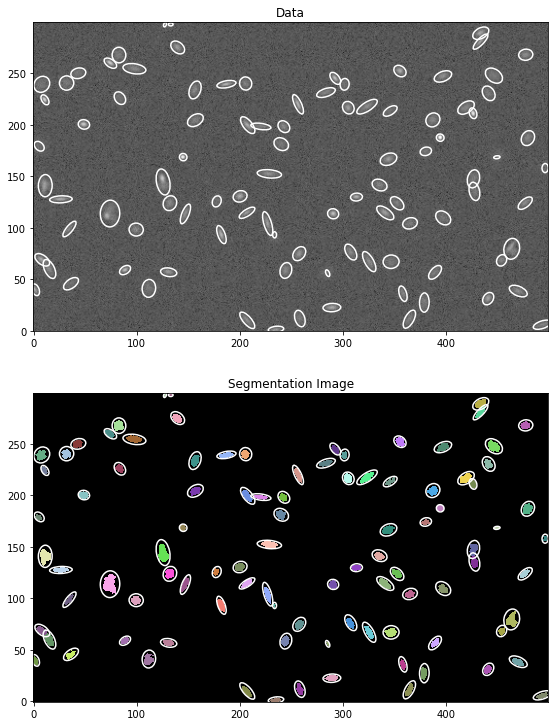

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)
    aperture.plot(axes=ax2, color='white', lw=1.5)

## Background Properties
Like with aperture_photometry(), the data array that is input to source_properties() should be background subtracted. If you input the background image that was subtracted from the data into the background keyword of source_properties(), the background properties for each source will also be calculated:

In [35]:
labels = [1, 5, 20, 50, 75, 80]
cat = source_properties(data, segm_deblend, labels=labels,
                        background=bkg.background)
columns = ['id', 'background_at_centroid', 'background_mean',
           'background_sum']
tbl4 = cat.to_table(columns=columns)
tbl4['background_at_centroid'].info.format = '{:.10f}'  # optional format
tbl4['background_mean'].info.format = '{:.10f}'
tbl4['background_sum'].info.format = '{:.10f}'
print(tbl4)

 id background_at_centroid background_mean background_sum
--- ---------------------- --------------- --------------
  1           5.2020428266    5.2021662094 187.2779835383
  5           5.2140031370    5.2139893924 302.4113847608
 20           5.2787968578    5.2785772173 385.3361368595
 50           5.1896511123    5.1895516008 171.2552028270
 75           5.1409531509    5.1408425626 185.0703322539
 80           5.2109780136    5.2108402505 286.5962137759


In [36]:
# Now use on GAMA09 data

In [37]:
import spectrum

In [45]:
c = spectrum.readSpectrum("../data/gama09E_028.fits.gz")

In [54]:
# take a random slice 400
from photutils.datasets import make_100gaussians_image
data = c.data[962]

#slice 340 holds source 67
#slice 962 holds source 137

In [55]:
from photutils import detect_threshold
threshold = detect_threshold(data, nsigma=2.)

In [56]:
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)

In [59]:
segm_deblend = deblend_sources(data, segm, npixels=5,
                               filter_kernel=kernel, nlevels=32,
                               contrast=0.001)

<ipython-input-60-ebadccc38840>:7: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm, vmin =0, vmax=0.05)


Text(0.5, 1.0, 'Segmentation Image')

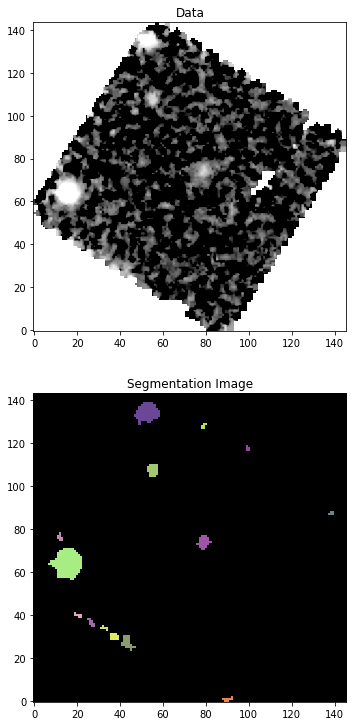

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm, vmin =0, vmax=0.05)
ax1.set_title('Data')

cmap = segm.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')

In [65]:
from photutils import source_properties
cat = source_properties(data, segm_deblend)
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['cxx'].info.format = '.2f'
tbl['cxy'].info.format = '.2f'
tbl['cyy'].info.format = '.2f'
tbl['gini'].info.format = '.2f'
tbl['source_sum'].info.format = '.2f'
tbl['ellipticity'].info.format = '.2f'
tbl['area'].info.format = '.2f'
print(tbl)

 id xcentroid ycentroid sky_centroid ...   cxx      cxy      cyy    gini
       pix       pix                 ... 1 / pix2 1 / pix2 1 / pix2     
--- --------- --------- ------------ ... -------- -------- -------- ----
  1     90.11      0.79         None ...     1.04    -2.44     3.99 0.26
  2     43.52     26.63         None ...     0.69     0.51     0.39 0.24
  3     37.29     29.71         None ...     1.03     0.40     1.82 0.21
  4     32.70     33.90         None ...     1.10     2.56     5.49 0.15
  5     26.58     36.29         None ...     2.58     2.72     2.08 0.35
  6     20.48     39.89         None ...     1.26     3.00     4.26 0.05
  7     15.72     64.02         None ...     0.17     0.01     0.17 0.55
  8     78.90     74.10         None ...     0.56    -0.13     0.40 0.16
  9     11.92     76.22         None ...     2.08     1.51     1.49 0.18
 10    138.20     87.45         None ...     2.13    -2.02     4.51 0.09
 11     55.15    107.60         None ...     0.73  

In [70]:
ii = np.array( tbl['area'] )> 25

In [71]:
tbl[ii]

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,
int64,float64,float64,object,object,float64,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7,15.72,64.02,None,None,12.79,None,None,None,None,7.0,22.0,57.0,71.0,-0.0011558214869388163,0.39639588783410196,10.0,66.0,15.0,64.0,160.00,7.136496464611085,47.62741699796952,2.4827005993807725,2.3887531763225445,-29.379767677419924,0.2724879991446794,0.04,1.0393290625374945,6.053650464607364,-0.19564946296911576,5.816293538949329,0.17,0.01,0.17,0.55
8,78.90,74.10,None,None,0.57,None,None,None,None,76.0,82.0,71.0,77.0,0.010669530385061281,0.031242220217786665,78.0,71.0,78.0,73.0,31.00,3.141274657157109,18.727922061357855,1.6347819170862852,1.3098804189108306,70.6455501690917,0.5983203614082816,0.20,1.2480390526378058,1.8208670556710347,0.2991506890943213,2.5674315726072887,0.56,-0.13,0.40,0.16
11,55.15,107.60,None,None,0.53,None,None,None,None,53.0,57.0,105.0,110.0,0.0075884683554362405,0.029207232793936215,57.0,109.0,55.0,106.0,26.00,2.876813695875796,16.242640687119284,1.5043549668987355,1.166285733887112,-83.97492805076915,0.6316263385148311,0.22,1.2898682742906176,1.370169568684517,-0.09424413759688541,2.253136710816978,0.73,0.06,0.45,0.18
14,52.51,134.97,None,None,4.38,None,None,None,None,47.0,58.0,129.0,139.0,-0.004664474282848616,0.16225756861323168,51.0,131.0,52.0,135.0,84.00,5.170882945826411,33.17766952966369,2.2210649310965653,1.9005652006874914,2.7472075599385377,0.5174722764441058,0.14,1.1686339044265042,4.930094827632814,0.06324114065827903,3.6151826825784616,0.20,-0.01,0.28,0.43


In [77]:
import numpy as np
import astropy.units as u
from photutils import source_properties, EllipticalAperture

r = 3.  # approximate isophotal extent
apertures = []
for obj in tbl[ii]:
    position = [obj["xcentroid"], obj["ycentroid"]]
    a = obj["semimajor_axis_sigma"]
    b = obj["semiminor_axis_sigma"]
    theta = obj.orientation.to(u.rad).value
    obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

15.715920129034142 pix
64.016000681355 pix
78.9011346205352 pix
74.09980714957987 pix
55.14622433823615 pix
107.59747935618671 pix
52.508171858450865 pix
134.96772105631106 pix


In [ ]:
import numpy as np
import astropy.units as u
from photutils import source_properties, EllipticalAperture
cat = source_properties(data, segm_deblend)
r = 3.  # approximate isophotal extent
apertures = []
for obj in tbl[ii]:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

In [78]:
print(position)

[434.10768081 288.89521589]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)
    aperture.plot(axes=ax2, color='white', lw=1.5)